# Build your own Blockchain! - IN5420 Programming Exercise

#### Acknowledgments

Thanks to Omkar Shanbhag and Simon Guo from the Berkley Blockchain Lab for the initial version of this notebook.

## Getting Started

This notebook is an introduction to Blockchain implementations, aimed at translating into code the concepts we learned during the course.

In this notebook we will implement several aspects of Blockchain technology, including: 

- The Blockchain data structure using OOP 
- The concept of difficulty of finding the next block hash 
- A simple PoW simulation 
- A simulation of multiple miners with varying computational powers 
- A data analytics task to evaluate PoW hardness

In [1]:
# import statements
import hashlib as hasher 
import random as rand
import time as tt
import datetime as date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Part 1 - Blockchain Data Structure Design

In this section we will define the class *Block* and implement an init function that creates a new block given some parameters, as well as a function *hash_block*, that computes the hash of this block based on its class variables. 

The init function is implemented for you below and creates a block with the following specifications 
- height: the height of the block on the chain (the genesis block has height=0)
- timestamp: time that the block is added on to the chain
- data: the data the block contains (it usually includes the merket root, but we can fill it with whatever for this)
- previous_hash: the hash value of the previous block 
- hash: hash of this block computed using the *hash_block* function
- nonce: the variable value that changes, altering the hash output (default value=0, irrelevant in this section)

**( ! ) Task 1: implement hash_block( )**

We need to implement the hash_block( ) which computes the hash value of this block. This function has no input parameters. 

Desired Functionality:
- Concatenate string representations of all the class variables 
- Computes the SHA256 hash of this concatenation 

**HINTS**

- Use the first import statement
- Initialize a new hasher
- Look into the following: 
    - utf-8 encoding 
    - .update() function 
    - .hexdigest() function
    - In order for the test function below to work properly, create the string concatenation in the following order with no spaces or any other characters in between 
       - height
       - timestamp
       - previous block hash
       - data
       - nonce
       
If you want to use a different variable order that incorporates everything that's totally fine, but test function wont work!

In [2]:
class Block:
    def __init__(self, height, timestamp, previous_hash, data, nonce=0):
        self.height = height
        self.timestamp = timestamp
        self.previous_hash = previous_hash
        self.data = data
        self.nonce = nonce # set to zero as default. Not used in the first part
        
        self.hash = self.hash_block()
        
    def __str__(self):
        return f"[Block {self.height}. Timestamp: {self.timestamp}. Data: {self.data}. Nonce: {self.nonce}]"
    
    def update_nonce(self, new_nonce):
        self.nonce = new_nonce
        self.hash = self.hash_block()
    
    def hash_block(self):
        str_height = str(self.height)
        str_timestamp = str(self.timestamp)
        str_previous_hash = str(self.previous_hash)
        str_data = str(self.data)
        str_nonce = str(self.nonce)
        block_str = str_height + str_timestamp + str_previous_hash + str_data + str_nonce
        m = hasher.sha256()
        m.update(block_str.encode('UTF-8'))
        return m.hexdigest()
        #return hasher.sha256(block_str.encode('UTF-8')).hexdigest()

**( ! ) Test your implementation of Task 1 here**

Run the block of code below

In [3]:
def test_task_1(height, time, previous_hash, data):
    new_block = Block(height, time, previous_hash, data)
    check_string = '771bd3218b062af12b12105602248140434874acf5dc592af8945788b298380c'
    print_statement = "PASSED!!! Move on to next Question" if str(new_block.hash) == check_string else "FAILED!!! Try Again"
    print(print_statement)
    
height = 0
time = '2022-01-24 15:05:06.612876'
previous_hash = '6ffd1464f68ef4aeb385d399244efa19293ba5c842c464a82c02f8256ef71428'
data = 'IN5420'

test_task_1(height, time, previous_hash, data)

PASSED!!! Move on to next Question


**Functions for Building the Chain**

Now that the Block class is completed, let's figure out how to make a chain made of several blocks. First, we need to have a function that creates a genesis block, which serves as the first block of our chain, and then implement the function *next_block( )* which builds a new block on top of a given block.

*create_genesis_block( )* has been implemented for you. It creates a block with the following specifications. 
- height = 0
- timestamp = Now (whenever the function is being called) 
- previous_hash = "0"
- data = "Genesis Block"


**( ! ) Task 2: Implement next_block( )**

Implement the function *next_block( )* which takes in 2 parameters:
- last_block = an instance of class Block that is the block that we're building our next block on top of 
- nonce = Dont do anything with this right now - just pass it in to the Block that you create using the default 

Implement the function so that it returns a new instance of the class Block with the following specifications
- height = height of last_block + 1
- timestamp = Now (whenever the function is being called)
- previous_hash = hash of last_block
- data = "Hey! I'm block {height}"  (for example block at height 5 would have data: "Hey! I'm block 5")


In [4]:
# Creates the first block with current time and generic data
def create_genesis_block():
    # Manually construct a block with height zero and arbitrary previous hash
    return Block(0, date.datetime.now(), "0", "Genesis Block" )

# Function that creates the next block, given the last block on the chain you want to mine on
def next_block(last_block, nonce=0):
    height = last_block.height + 1
    return Block(height, date.datetime.now(), last_block.hash, f"Hey! I'm block {height}")

**( ! ) Test your Task 2 implementation here**: Run the block of code below



In [5]:
def test_task_2(genesis_block):
    block_1 = next_block(genesis_block)
    if block_1.height == 1 and block_1.data == "Hey! I'm block 1" and block_1.previous_hash == genesis_block.hash and str(type(block_1.timestamp)) == "<class 'datetime.datetime'>":
        print("PASSED!!! Move on to next part" )
    else:
        print("FAILED!!! Try again :(")
    

genesis_block = create_genesis_block()
test_task_2(genesis_block)

PASSED!!! Move on to next part


**Spinning up a Chain**

Now that you have implemented the data structure as well as the functions needed to create the chain, let's see how to spin up an actual blockchain instance.

Below we initialize three different variables: 
- blockchain - this is a python list which we initialize with one block inside (the genesis block) 
- previous_block - this points to our genesis block (since it references the first element in blockchain)
- num_blocks - this specifies the number of additional blocks we want to add to our chain 

**( ! ) Task 3: implement complete_chain( )**

Complete the implementation of the function *complete_chain( )*. This function takes in three inputs, which correspond to the initializations that we made. It returns nothing however, upon completion, the list "blockchain" that we initialized earlier has been turned into an array of length num_blocks + 1 in which each element is an instance of class Block and each element's self.previous_hash == the previous element's self.hash. Therefore we have created our own mini blockchain!! 

The for loop and the print statements of complete_chain have been implemented for you, you need to add the statements that ***create a new block on top of previous_block, add it to the block chain, and edit previous block so that the for loop can continue correctly*** 

****HINT**** : Literally just do all the things listed in the section immediately above in order 

If it works out, you should get the same number of print statements as num_blocks

In [6]:
#[ORIGINAL CODE]
# Create the blockchain and add the genesis block
blockchain = [create_genesis_block()]

# Create our initial reference to previous block which points to the genesis block
previous_block = blockchain[0]

# How many blocks should we add to the chain after the genesis block
num_blocks = 10

def complete_chain(num_blocks, blockchain, previous_block):
    # Add blocks to the chain
    for i in range(0, num_blocks):
        # Your code for Task 3 Here
        block_to_add = next_block(previous_block)
        blockchain.append(block_to_add)
        previous_block = blockchain[i+1]
        # TIP: name the newly created block "block_to_add"
        
        print(blockchain)
        # Your code for Task 3 ends Here
        print("Block #{} has been added to the blockchain!".format(block_to_add.height))
        print("Hash: {}\n".format(block_to_add.hash))
        print(type(block_to_add.hash))
        tt.sleep(1)         

complete_chain(num_blocks, blockchain, previous_block)

[<__main__.Block object at 0x00000210539D3E50>, <__main__.Block object at 0x00000210539D3730>]
Block #1 has been added to the blockchain!
Hash: 1305d47e73852c2e24c7c5cf00bff90af27e3d9e0e51aeeedd147501da7d7b09

<class 'str'>
[<__main__.Block object at 0x00000210539D3E50>, <__main__.Block object at 0x00000210539D3730>, <__main__.Block object at 0x00000210539D3AC0>]
Block #2 has been added to the blockchain!
Hash: 7ea57b8c838d0ce1a7c5935192e8ea79852b568d5b0c7fdd4cf8f76a394a681d

<class 'str'>
[<__main__.Block object at 0x00000210539D3E50>, <__main__.Block object at 0x00000210539D3730>, <__main__.Block object at 0x00000210539D3AC0>, <__main__.Block object at 0x000002104E891730>]
Block #3 has been added to the blockchain!
Hash: a9259ed8c4ee84c44977267b599b6ddbfee14f4bca4bf62cd49e399b404b9ee2

<class 'str'>
[<__main__.Block object at 0x00000210539D3E50>, <__main__.Block object at 0x00000210539D3730>, <__main__.Block object at 0x00000210539D3AC0>, <__main__.Block object at 0x000002104E891730>

**( ! ) Test your Task 3 implementation here**: Run the block of code below.

In [7]:
def test_task_3(blockchain, num_blocks):
    correct = True
    if len(blockchain) != num_blocks + 1:
        correct = False
    for i in range(len(blockchain)-1):
        if blockchain[i + 1].previous_hash != blockchain[i].hash:
            correct = False
            break
    print_statement = "PASSED!!! Move on to the next Part" if correct else "FAILED!!! Try Again :("
    print(print_statement)

test_task_3(blockchain, num_blocks)

PASSED!!! Move on to the next Part


# Part 2 - Proof of Work Simulation

In this part you will implement a simulation of the Proof-of-Work mechanism that Bitcoin (among other blockchains) uses. Let us define again some of the concepts that we discussed in class.

- **nonce**: a randomly generated value that is concatenated to the block to vary the resulting digest.

- **difficulty** : specified by the network (in theory. Here it is specified by us). Defines the number of leading zeros and, as a consequence, limits the number of hashes that are valid out of all possible values. Higher difficulty indicates a lower number of valid hashes. 

The functions **generate_nonce( )** and **generate_difficulty_bound( )** have been implemented for you.

Complete the implementation of **find_next_block( )**. This function's purpose is to try different blocks with the same data, height etc. but different nonces that satisfy the difficulty specified. The difficulty bound has already been generated for you and the first block has been created. You have to complete the implementation so that: 
- You find a nonce such that the hash of the block is less than the difficulty bound. 
- All data from new block has to be the same (including the timestamp, for simplicity purposes) and the only thing changing is the nonce 
- For our learning purposes, increment the hashes_tried parameter appropriately everytime you try a hash so that we can see the number of hashes tried and how this correlates to our difficulty value. 

**( ! ) Task 4: implement find_next_block( )**

**HINTS**
- How do you turn a hash string into its hex prepresentation that you can compare???
- if your implementation is working, you should notice something interesting about all the hashes of the blocks that you are getting when you run the code cell labeled "Create Proof of work Blockchain"**



**you can test question 4 in the a few cells below this one, after running all the cells in between**

In [35]:
def generate_nonce(length=20):
    return ''.join([str(rand.randint(0, 9)) for i in range(length)])

def generate_difficulty_bound(number_leading_zeros=1):
    return "0" * number_leading_zeros

# Given a previous block and a difficulty value, find a nonce that results in a lower hash value
def find_next_block(last_block, difficulty, nonce_length):
    difficulty_bound = generate_difficulty_bound(difficulty)
    start = tt.time()
    new_block = next_block(last_block)
    hashes_tried = 1 
    
    
    #Your code for Task 4 Starts here
    while new_block.hash[:len(difficulty_bound)] != difficulty_bound: 
        hashes_tried += 1
        new_block = next_block(last_block)
       
    
    #Your code for Task 4 Ends here 
    time_taken = tt.process_time() - start
    return(time_taken, hashes_tried, new_block)
        

<class 'bytes'>
b'0'
False


The cell below creates our proof of work blockchain in a similar way that we do in the earlier section. 

Some initializations:
- blockchain_pow: Our new python list that signifies our proof of work blockchain, with the genesis block inside
- previous_block: The first block to use as previous block to build upon
- num_blocks: number of additional blocks to add to the chain
- difficulty: difficulty of the network 
- nonce_length: length of the randomly generated nonce

### Create Proof of Work Blockchain 


In [37]:
# Create the blockchain and add the genesis block
blockchain_pow = [create_genesis_block()]

#Create our initial reference to previous block which points to the genesis block
previous_block = blockchain_pow[0]

# How many blocks should we add to the chain after genesis block
num_blocks = 10

# number of leading zeroes that must be in the beginning of the hash
difficulty = 4

#length of nonce that will be generated and added
nonce_length = 20

# Add blocks to the chain based on difficulty with nonces of length nonce_length
def create_pow_blockchain(num_blocks, difficulty, blockchain_pow, previous_block, nonce_length, print_data=1):
    hash_array = []
    time_array = []
    for i in range(0, num_blocks):
        time_taken, hashes_tried, block_to_add = find_next_block(previous_block, difficulty, nonce_length)
        blockchain_pow.append(block_to_add)
        previous_block = block_to_add
        hash_array.append(hashes_tried)
        time_array.append(time_taken)
        # Tell everyone about it!
        if print_data:
            print("Block #{} has been added to the blockchain!".format(block_to_add.height))
            print("{} Hashes Tried!".format(hashes_tried))
            print("Time taken to find block: {}".format(time_taken))
            print("Hash: {}\n".format(block_to_add.hash))
    return(hash_array, time_array)

hash_array, time_array = create_pow_blockchain(num_blocks, difficulty, blockchain_pow, previous_block, nonce_length)

Block #1 has been added to the blockchain!
6125020 Hashes Tried!
Time taken to find block: -1647687914.5162275
Hash: 0000b2795c378ada7f2fc45a8982aed4d9b3b6741f31be6a14cd91ff836fb458

Block #2 has been added to the blockchain!
4290313 Hashes Tried!
Time taken to find block: -1647687932.1700485
Hash: 00007ba1e3a04e29d5877f68336f167e6914cced7f81f805d8319eb378d665ad

Block #3 has been added to the blockchain!
599257 Hashes Tried!
Time taken to find block: -1647687965.5619717
Hash: 00000e86ea771fc59d91bcd3de9d4fe5e82bb8fd31625c178d23272ee600772f

Block #4 has been added to the blockchain!
16126240 Hashes Tried!
Time taken to find block: -1647687826.131877
Hash: 0000fc3da73659aacf86072c0d2962bdef21ecc8e7ad6cf56941fa4ca1cf1f39

Block #5 has been added to the blockchain!
4280271 Hashes Tried!
Time taken to find block: -1647687932.9598444
Hash: 00009f0809e33f8cf999d73f71df1eeca982a9b4c4424feb79643156e4dc96c2

Block #6 has been added to the blockchain!
14466172 Hashes Tried!
Time taken to find b

**( ! ) Test your Task 4 implementation here**

Run the block of code below.

In [39]:
def test_task_4(blockchain_pow, num_blocks):
    correct = True
    difficulty_bound = generate_difficulty_bound(difficulty)
    if len(blockchain_pow) != num_blocks + 1:
        correct = False
    for i in range(len(blockchain_pow) - 1):
        if blockchain_pow[i + 1].previous_hash != blockchain_pow[i].hash:
            correct = False
            break
        if blockchain_pow[i + 1].hash[:difficulty] != difficulty_bound:
            correct = False
            break
    print_statement = "PASSED!!! Move on to the next Part" if correct else "FAILED!!! Try Again :("
    print(print_statement)
            
test_task_4(blockchain_pow, num_blocks)

PASSED!!! Move on to the next Part


Once you have passed the above test case, you can play around with the difficulties and nonce lengths and see what happens 

# Part 3 - Distributed Network and Computing Power Simulation

In this section, instead of simulating a single node executing the PoW in isolation, we will create a group of nodes that compete to propose blocks. These nodes have different computing powers, specified by us. Below we define the *MinerNodeNaive* class which has an init function to create an instance, as well as a *try_hash( )* function that allows the miner to try a hash and see if it produces a valid block. 

In [40]:
# Naive miner class that races with other miners to see who can get a certain number of blocks first 
class MinerNodeNaive: 
    def __init__(self, name, compute):
        self.name = name 
        self.compute = compute
    
    def try_hash(self, difficulty, chain):
        last_block = chain[-1]
        difficulty_bound = generate_difficulty_bound(difficulty)
        this_height = last_block.height + 1
        this_timestamp = date.datetime.now()
        this_hash = last_block.hash
        this_data = "Hey! I'm block " + str(this_height)
        
        new_block = Block(this_height, this_timestamp, this_data, this_hash)
        
        if new_block.hash[:difficulty] == difficulty_bound:
            chain.append(new_block)
            # Tell everyone about it!
            print("Block #{} has been added to the blockchain!".format(new_block.height))
            print("Block found by: {}".format(self.name))
            print("Hash: {}\n".format(new_block.hash))
        

**( ! ) Task 5: Describe the Following Cells**

In the next cells we try to simulate a group of miners with different computing powers. However this isn't completely indicative of how a real system works, and is limited by our single threaded implementation. Read through the code, run all the cells and explain what is happening in a paragrpah. Also explain how this is different from real world vanilla PoW systems and how this simulation isn't completely accurate of what is actually happening while nodes race to find the next block. There is a cell at the bottom where you can enter your description.  

In [64]:
# Initialize multiple miners on the network 
UiO_Miner = MinerNodeNaive("UiO Miner", 10)
berkeley_Miner = MinerNodeNaive("Berkeley Miner", 10)
stanford_Miner = MinerNodeNaive("Stanford Miner", 7)
MIT_Miner = MinerNodeNaive("MIT Miner", 5)
UCLA_Miner = MinerNodeNaive("UCLA Miner", 3)

miner_array = [UiO_Miner, berkeley_Miner, stanford_Miner, MIT_Miner, UCLA_Miner]

In [63]:
def create_compute_simulation(miner_array):
    compute_array = []
    for miner in miner_array:
        for i in range(miner.compute):
            compute_array.append(miner)
    return(compute_array)

compute_simulation_array = create_compute_simulation(miner_array)
rand.shuffle(compute_simulation_array)

In [66]:
chain_length = 10 
chain_difficulty = 4
blockchain_distributed = [create_genesis_block()]
genesis_block_dist = blockchain_distributed[0]

while len(blockchain_distributed) <= chain_length:
    sampled_miner = rand.sample(compute_simulation_array, 1)[0]
    sampled_miner.try_hash(chain_difficulty, blockchain_distributed)
        

Block #1 has been added to the blockchain!
Block found by: Stanford Miner
Hash: 00008d3a71a276894ae280c10cfd605770d88c23d17d614fd7cb1cf49eb2ae58

Block #2 has been added to the blockchain!
Block found by: UCLA Miner
Hash: 00001113ddea2569d65b25ce5055fcb4eda4160af56004a56a3624737f935d49

Block #3 has been added to the blockchain!
Block found by: UiO Miner
Hash: 0000e4243572b2865c975a2f3713b73b4df283a78c1f346aa846576d3cbd24ff

Block #4 has been added to the blockchain!
Block found by: Berkeley Miner
Hash: 00006eace3bee45b8161df5c661047ac0e93bd7e888d0885b475a152edc0b33d

Block #5 has been added to the blockchain!
Block found by: Berkeley Miner
Hash: 0000b4da1f25c3b1ec1ee77138c0dfd80e56516413d0c50c3be47fe567583a26

Block #6 has been added to the blockchain!
Block found by: Berkeley Miner
Hash: 00003052337e603c4703820ea55a91b02b69ec6ed711f82f78dd6dda2771b005

Block #7 has been added to the blockchain!
Block found by: Stanford Miner
Hash: 0000eee0e281628457327ce565c46ac29c10de1b607d5f832debf

**( ! ) Task 5 Description Here**

**## Your description Here ##**
1. Setting up miners, their name, and their computing power using MinerNodeNaive class. Create a list that includes all miners' objects.

2. create_compute_simulation iterating through miner_array for each miner and filling compute_array according to their computing power. If UiO has 10 computing power, it will be added 10 times to the list. rand.shuffle(compute_simulation_array) reordering the list items (miners).

3. Specifying chain length and difficulty. blockchain_distributed array is created with 1st item of the genesis block, which is selected as genesis_block_dist in the next line. While loop in the next line runs until a number of blocks in blockchain_distributed equals to chain length. Each time while loop runs it randomly selects 1 miner from the compute_simulation_array and a selected miner will find hash (using try_hash which uses .hash from Block class) lower than difficulty bound and append the block to the blockchain.

Here we are randomly selecting from the list and the more miners appear in the list, the higher chances to be selected to mine the next block. But in real life mining pools gather big computing power and try to solve puzzles faster trying different nonces and also changing coinbase addresses. Also, fast internet matters because it affects broadcast time.  

# Blockchain Data Analytics

In this section we are going to analyze the average time and number of hashes needed to propose a valid block, given a fixed difficulty level. Look and understand the code, run all of the cells, and answer the question at the bottom. 

NOTE: difficulty level 4 may take some time to complete so do not be alarmed if the next cell takes a while to run

In [44]:
blockchain = [create_genesis_block()]
previous_block = blockchain[0]
num_blocks = 100

# 4 different types of difficulty to analyze
difficulty_1 = 1
difficulty_2 = 2
difficulty_3 = 3
difficulty_4 = 4

nonce_length = 20

hash_array_1, time_array_1 = create_pow_blockchain(num_blocks, difficulty_1, blockchain, previous_block, nonce_length, 0)
print("Difficulty Level: {} complete".format(difficulty_1))
hash_array_2, time_array_2 = create_pow_blockchain(num_blocks, difficulty_2, blockchain, previous_block, nonce_length, 0)
print("Difficulty Level: {} complete".format(difficulty_2))
hash_array_3, time_array_3 = create_pow_blockchain(num_blocks, difficulty_3, blockchain, previous_block, nonce_length, 0)
print("Difficulty Level: {} complete".format(difficulty_3))
hash_array_4, time_array_4 = create_pow_blockchain(num_blocks, difficulty_4, blockchain, previous_block, nonce_length, 0)
print("Difficulty Level: {} complete".format(difficulty_4))

Difficulty Level: 1 complete
Difficulty Level: 2 complete
Difficulty Level: 3 complete
Difficulty Level: 4 complete


In [45]:
dfHashesNeeded = pd.DataFrame(columns=["difficulty", "hashNumber"])
dfTimeNeeded = pd.DataFrame(columns=["difficulty", "time"])

for index in range(num_blocks):
    dfHashesNeeded = dfHashesNeeded.append({"difficulty":1, "hashNumber": hash_array_1[index]}, ignore_index=True)
    dfHashesNeeded = dfHashesNeeded.append({"difficulty":2, "hashNumber": hash_array_2[index]}, ignore_index=True)
    dfHashesNeeded = dfHashesNeeded.append({"difficulty":3, "hashNumber": hash_array_3[index]}, ignore_index=True)
    dfHashesNeeded = dfHashesNeeded.append({"difficulty":4, "hashNumber": hash_array_4[index]}, ignore_index=True)
    
    dfTimeNeeded = dfTimeNeeded.append({"difficulty":1, "time": time_array_1[index]}, ignore_index=True)
    dfTimeNeeded = dfTimeNeeded.append({"difficulty":2, "time": time_array_2[index]}, ignore_index=True)
    dfTimeNeeded = dfTimeNeeded.append({"difficulty":3, "time": time_array_3[index]}, ignore_index=True)
    dfTimeNeeded = dfTimeNeeded.append({"difficulty":4, "time": time_array_4[index]}, ignore_index=True)

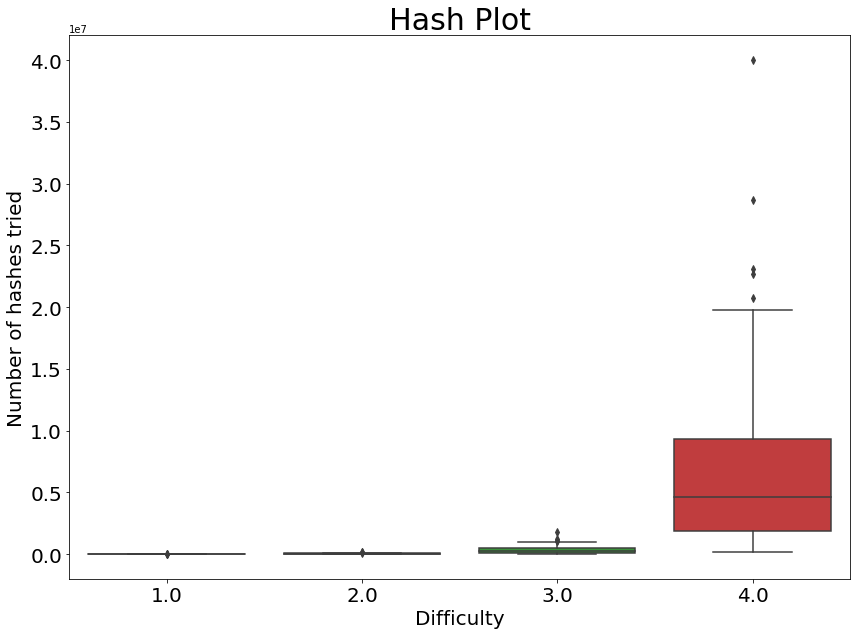

In [46]:
def plotHashTrend(dataset):

    dataset.difficulty = dataset.difficulty.astype(float)
    dataset.hashNumber = dataset.hashNumber.astype(float)
    plt.figure(figsize=(14, 10))
    
    b = sns.boxplot(x="difficulty", y="hashNumber", data=dataset)

    b.axes.set_title(f"Hash Plot", fontsize=30)
    b.set_xlabel("Difficulty", fontsize=20)
    b.set_ylabel("Number of hashes tried", fontsize=20)
    b.tick_params(labelsize=20)

    plt.show()
    
plotHashTrend(dfHashesNeeded)

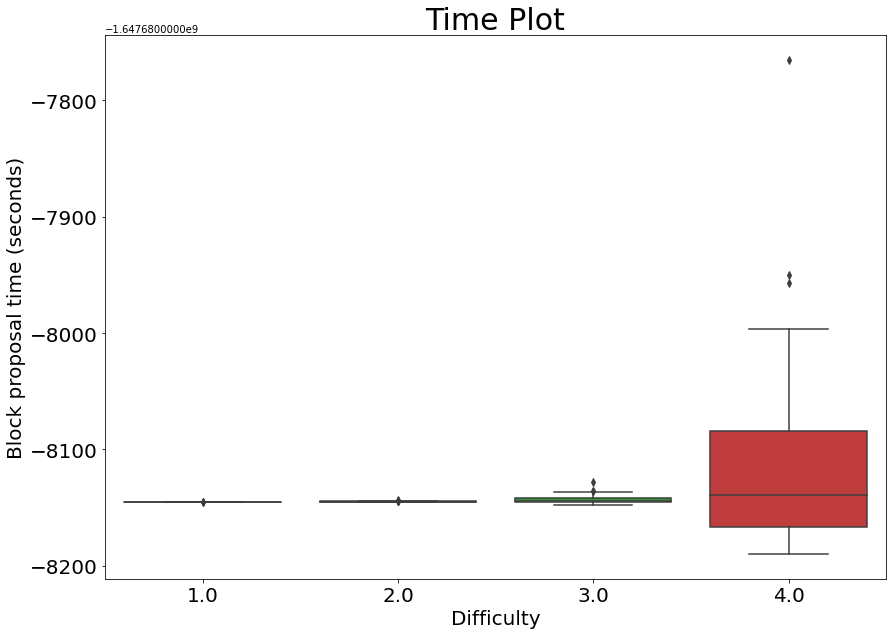

In [55]:
def plotTimeTrend(dataset):

    dataset.difficulty = dataset.difficulty.astype(float)
    dataset.hashNumber = dataset.time.astype(float)
    plt.figure(figsize=(14, 10))
    
    b = sns.boxplot(x="difficulty", y="time", data=dataset)

    b.axes.set_title(f"Time Plot", fontsize=30)
    b.set_xlabel("Difficulty", fontsize=20)
    b.set_ylabel("Block proposal time (seconds)", fontsize=20)
    b.tick_params(labelsize=20)

    plt.show()
    
plotTimeTrend(dfTimeNeeded)

In [49]:
diff_factor_1 = np.mean(hash_array_2)/np.mean(hash_array_1)
diff_factor_2 = np.mean(hash_array_3)/np.mean(hash_array_2)
diff_factor_3 = np.mean(hash_array_4)/np.mean(hash_array_3)
print("Factor of difficulty increase from 1 to 2: {}".format(diff_factor_1))
print("Factor of difficulty increase from 2 to 3: {}".format(diff_factor_2))
print("Factor of difficulty increase from 3 to 4: {}".format(diff_factor_3))

Factor of difficulty increase from 1 to 2: 21.496185551859124
Factor of difficulty increase from 2 to 3: 10.630959180819492
Factor of difficulty increase from 3 to 4: 20.104556010564757


**( ! ) Task 6**

Look at the factor of difficulty increase from each level to the subsequent level, printed from the cell above.

What whould the factor of difficulty increase be for each level: **Your answer Here**

As we can see from the results:

Factor of difficulty increase from 1 to 2: 21.496185551859124

Factor of difficulty increase from 2 to 3: 10.630959180819492

Factor of difficulty increase from 3 to 4: 20.104556010564757




**( ! ) Optional Extra Tasks**

Feel free to extend the code and investigate/test cases you are curious about. Curiosity will be positively evaluated ;)